In [8]:
import nibabel as nib
import numpy as np
from sklearn.linear_model import Lasso,LassoCV,LinearRegression,Ridge
from sklearn.decomposition import TruncatedSVD, KernelPCA
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom

from orelmisc import n_max,n_test_max,testpre,trainpre,saveCSV,y_org,shape_3d_org
from preprocess import flatten,flatten_each_sample,loadData,flatten_each_sample,precompute_and_save

In [9]:
prep = lambda i: i # int(i)
# don't round to the nearest integer anymore.
# it seems we can submit floating-point age xD HAHA... ... I should have tried this out before...
# ... But it seems that itdoesn't actually affect the score ... (changes in 0.05...)

x_org = None
x_t_org = None
xa_org = None
d_org = None
y = y_org
y_t_pred = None
y_t_pp = None
y_best = [60.41677586954188, 70.556846873091274, 51.259856559229263, 74.547095580553503, 71.505907608786515, 72.346464000209949, 52.727406903739166, 54.874465555419022, 63.227983499721631, 52.886178566197771, 29.826328352545204, 55.075224163736607, 61.901448596608361, 38.132208232209223, 31.046176955295891, 62.537097548010365, 24.908355766894033, 69.086668371481267, 89.754394318519871, 81.004224561481749, 86.561319628271065, 32.435515384943187, 69.895617096792648, 87.577051526701268, 65.190580013885381, 49.290209978857774, 72.471147821959732, 17.041278673459658, 27.10198322237477, 33.413051921369743, 67.468656726710208, 43.888664476115707, 11.732545422835187, 27.161584878040514, 25.273463412581236, 61.878440639810947, 80.613147168592377, 87.671031986084927, 61.17387202751155, 84.642082300218931, 37.922406914169471, 67.385507256406925, 82.779736124807016, 32.249900877637401, 60.220286886504937, 55.784435814279902, 42.823661567639817, 34.148244775199203, 27.9153670985948, 70.866743202301279, 24.326357855750814, 78.728773910887469, 19.146997786101622, 48.963633784129854, 28.64830015797321, 84.304440687776719, 71.763444850488327, 76.210941860909259, 18.255051308767577, 51.12824916236417, 59.798239106452627, 75.320795126807297, 44.753506232459813, 56.987507240632567, 14.541255486955379, 36.226903669822264, 25.279335728336548, 31.393441111395873, 78.415831303532514, 71.498148006348572, 81.879612545441887, 73.288079131811514, 6.6352423555986206, 13.624849190374732, 76.761258449791967, 69.912351002996274, 50.286570024679008, 55.347189707317966, 58.025709680417833, 34.164022714234591, 67.579736169835201, 77.909177058113471, 79.817254486844831, 35.565554755817288, 35.504528057553955, 84.521795508831588, 16.617970158446326, 45.922224883991646, 34.069841009630068, 76.750369451665335, 26.118926638149389, 65.099086360501815, 45.350769428631452, 26.590664106164638, 63.582494944171572, 83.366742976622163, 66.704138195733833, 75.560473528383511, 61.137038310493153, 53.218041397689831, 55.875796813369391, 41.867934266006216, 47.470916205177502, 79.589337296937117, 23.331024126881744, 36.430585026937479, 84.723952888332747, 33.919367103167019, 25.619021418080081, 60.879006342867854, 32.244306197392632, 31.838743852776986, 12.01133784289749, 70.313418718516573, 86.280925090015899, 34.298127800017028, 68.058578302756473, 67.485237849794657, 40.803976228666272, 21.745153770381933, 33.936638211675756, 22.775514949898081, 37.543538725362907, 37.180415628623678, 68.465893356282834, 29.364175087756905, 41.645200951135791, 48.574970368286472, 34.759113129253876, 81.130339421624853, 11.926194768784285, 40.939994530693752, 19.230366527062642, 25.498732936363126, 20.018983707980453, 11.769574571695046, 91.599540898394764, 81.735395094048272]
prefix=None
alpha = 10
result = None
xa = []
x = None
x_t = None

In [10]:
name = "mean_var_mean_std_hist500_scale1"
#fname = "ax_1_2_3_avg_var.npy"
#fname = "mean_std_loghist_scale2.npy"
#fname = "mean_std_hist120_scale1.npy"
fname = "mean_std_hist500_scale1.npy"

xa = np.load(fname)
x = xa[0:n_max,:]
x_t = xa[n_max:,:]
space = 500
bins = np.linspace(250,2600,space-1)

In [11]:
def myloop(a):
    return (a,a*a,a*a*a)

myloopU = np.frompyfunc(myloop,1,3,dtype=np.float64)

def loadAndPreprocess():
    global d_org,x,x_t,xa,x_org,x_t_org,xa_org
    
    d_org = 6443008
    """if x_org == None:
        x_org = loadData(scale=2,train=True)
        x_t_org = loadData(scale=2,train=False)
        d_org = 88*88*104# 6443008

        xa_org = np.zeros((n_max+n_test_max,d_org))
        xa_org[0:n_max] = x_org
        xa_org[n_max:] = x_t_org
        xa = np.zeros((n_max+n_test_max,5+space-1))
    """
    xa = np.zeros((n_max+n_test_max,5+space-1))
    
    i = 0
    while i < n_max+n_test_max:
      if i % 5 == 0:
        print "Doing i = %s ..." % i
      
      n_i,pre,t_str = (n_max,"set_train/","train") if i < n_max else (n_test_max,"set_test/","test")
      filename = "%s%s_%s.nii" % (pre,t_str,i%n_max+1)
      data = nib.load(filename).get_data()
      #data=xa_org[i]
      sum = 0.0
      sum2 = 0.0
      sum3 = 0.0
      avg = 0.0
      var = 0.0
      data = data.ravel()
      res = myloopU(data)
      sum = np.sum(res[0])
      sum2 = np.sum(res[1])
      sum3 = np.sum(res[2])
      avg = sum / float(d_org)
      var = sum2 - avg*avg
      xa[i,:5] = [sum,sum2,sum3,avg,var]
      xa[i,5:] = np.histogram(data,bins=bins)[0]
      i = i+1
    x = xa[0:n_max]
    x_t=xa[n_max:]

## SCHLUSSFOLGERUNG: brauche ein isschen mehr sachen als nur diese momente und summen.
# vielleicht ein grobes histogram?
# pures Lasso und SVD+Lasso waren am besten... mit RSS 155...

## SCLUSSFOLGERUNG 2:
# Pures Lasso mit alpha = 750 war gut. RSS 84 ..
# SVD auf das Histogram bringt keinen Mehrwert...
# Das Ergebnis wrde allein durch die Momente und Statistischen Werte erreicht!!
# [sum,sum2,sum2,avg,var]

# SCHLUSSFOLGERUNG 3:
# Pures Lasso auf den statistischen daten und dem histogram. Mit alpha = 870 wurde bis zu RSS 77 erreicht!
# wir sind damit unter der öffentlichen Schranke von 80 angelangt!

In [12]:
#print y
#loadAndPreprocess()

In [13]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def makeGaussianProcess():
  global y_t_pred,resulty
  prefix = "%s_GPs_FULL"%(name)
  kernel = RBF(1e5,(1e-4,1e15))
  model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9)
  y_t_pred = model.fit(x[:,:5],y).predict(x_t[:,:5])
  r = model.score(x[:,:5],y)
  print("score r = %s"%r)
  print "Coefficients: %s" % model.get_params()
  return prefix,model

def makeSVDLassoPrediction(comps,al=15):
  global y_t_pred,result,alpha
  alpha = al
  svd = TruncatedSVD(n_components=comps,n_iter=20)
  print "Prediction with alpha = %s" % alpha
  prefix = "%sSVD_Lasso_comps%s_alpha%s_FULL"%(name,comps,alpha)
  #x1 = np.concatenate((x[:,:5],svd.fit_transform(x)),axis=1)
  #x1 = svd.fit_transform(x)
  #x_t1 = svd.transform(x_t)
  #x_t1 = np.concatenate((x_t[:,:5],svd.transform(x_t)),axis=1)
  x1 = x[:,:5]
  x_t1 = x_t[:,:5]
  lasso = Lasso(alpha=alpha)
  y_t_pred = lasso.fit(x1,y).predict(x_t1)
  r = lasso.score(x1,y)
  print("score r = %s"%r)
  print "Intercept: %s" % lasso.intercept_
  print "Coefficients: %s...." % lasso.coef_[:5]
  #print "singular values of x0: %s" % np.sort(x1[0])
  plt.clf()
  plt.plot(np.sort(x1[0]))
  plt.show()
  return prefix,lasso
 
def makeRidgePrediction(al):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction with alpha = %s" % alpha
  prefix = "%s_Ridge_alpha%s_FULL"%(name,alpha)
  model = Ridge(alpha=alpha)
  y_t_pred = model.fit(x,y).predict(x_t)
  r = model.score(x,y)
  print("score r = %s"%r)
  print "Intercept: %s" % model.intercept_
  #print "Coefficients: %s" % model.coef_
  return prefix,model
    
def makeLassoPrediction(al):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction with alpha = %s" % alpha
  prefix = "%s_LassoPure_alpha%s_FULL"%(name,alpha)
  model = Lasso(alpha=alpha)
  x1 = x # use all data
  x_t1 = x_t # use all data
  y_t_pred = model.fit(x1,y).predict(x_t1)
  r = model.score(x1,y)
  print("score r = %s"%r)
  print "Intercept: %s" % model.intercept_
  print "Coefficients: %s..." % model.coef_[:5]
  bla1 = (sorted(enumerate(model.coef_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest coefficients: %s..." % bla1
  plt.clf()
  plt.plot(model.coef_,"ro")
  plt.title("Most relevant coef:%s"%(bla1))
  plt.savefig(prefix+"_coefficients.png")
  plt.show()
  return prefix,model

def make_KPCA_prediction(kernel,al):
  global y_t_pred,result,alpha
  alpha = al
  print "Prediction KPCA and alpha = %s" % alpha
  prefix = "%s_KPCA_Lasso_kernel_%s_alpha%s" % (name,kernel,alpha)
  kpca = KernelPCA(kernel=kernel,fit_inverse_transform=True)
  x1 = kpca.fit_transform(x)
  x_t1 = kpca.transform(x_t)
  lasso = Lasso(alpha=alpha)
  y_t_pred = lasso.fit(x1,y).predict(x_t1)
  r = lasso.score(x1,y)
    
  print "Intercept: %s" % lasso.intercept_
  print "Coefficients: %s..." % lasso.coef_[:5]
  bla1 = (sorted(enumerate(lasso.coef_),key=lambda x:-abs(x[1]))[:5])
  print "Abs-Val largest coefficients: %s..." % bla1
  return prefix,lasso


def makeLassoCVPrediction(cv=3):
  global y_t_pred,result
  print "Prediction with cv = %s" % 3
  prefix = "%s_LassoCV_FULL"%(name)
  lasso = LassoCV(cv=cv)
  y_t_pred = lasso.fit(x,y).predict(x_t)
  r = lasso.score(x,y)
  m_log_alphas = -np.log10(lasso.alphas_)
  plt.plot(m_log_alphas, lasso.mse_path_, ':')
  plt.show()
  print("score r = %s"%r)
  print "Intercept: %s" % lasso.intercept_
  #print "Coefficients: %s" % lasso.coef_
  return prefix,lasso


def makeLinearRegression():
  global y_t_pred,result
  prefix = "%s_LinReg_FULL"%(name)
  linreg = LinearRegression()
  y_t_pred = linreg.fit(x,y).predict(x_t)
  r = linreg.score(x,y)
  print("score r = %s"%r)
  print "Intercept: %s" % linreg.intercept_
  print "Coefficients: %s" % linreg.coef_
  print "Residues: %s" % linreg.residues_
  return prefix,linreg

In [14]:
def doStuff(al=15,comps=n_max-1,kernel="rbf"):
  global prefix,result
  #loadAndPreprocess()
  
  prefix,model = makeLassoPrediction(al=al)
  #prefix,model = makeSVDLassoPrediction(al=al,comps=comps)
  #prefix,model = makeLassoCVPrediction(cv=3)
  #prefix,model = makeLinearRegression()
  #prefix,model = makeRidgePrediction(al=al)
  #prefix,model = makeGaussianProcess()
  #prefix,model = make_KPCA_prediction(kernel=kernel,al=al)
  
  y_t_pp = savePrediction()
  
  visualize(y,y_t_pp,prefix)
  
  print " ========= x ========== \n%s\n" % x
  print " ========= y_t_pp ========== \n%s\n" % y_t_pp
  
  # retuns a colleciton of stuff to return
  print "Variables available in 'result'"
  result = (x,y,x_t,y_t_pred,y_t_pp,model)

def visualize(y,y_t_pp,prefix):
  """ Step 5: make histogram plot of age """
  # (because no visualization for flat data matrix...)
  plt.hist(y,color="black",rwidth=0.7)
  #plt.hist(y_pred,color="darkgreen",rwidth=0.5)
  plt.hist(y_t_pp,color="darkblue",rwidth=0.5)
  plt.legend(["ages given for X",
    #"ages predicted for X",
    "ages predicted for X_t"])
  plt.savefig(prefix + "_histogram_ages.png")
  plt.show()
  plt.clf()
  plt.clf()
  plt.plot(np.array(y_t_pp)-np.array(y_best),"bo")
  plt.savefig(prefix + "_diff_to_score_77.png")
  print("Saved age diagrams as %s"%(prefix+"*.png"))
  plt.show()

def savePrediction():
    global y_t_pp
    y_t_pp = [prep(i) for i in y_t_pred]
    savedFilename = saveCSV(y_t_pp,prefix)
    print("Saved predictions into %s" % savedFilename)
    return y_t_pp

Prediction with alpha = 210
score r = 0.90372618922
Intercept: 372.181225724
Coefficients: [ -1.16794434e-07  -4.97750629e-11  -3.48023409e-15   0.00000000e+00
   8.13773196e-12]...
Abs-Val largest coefficients: [(115, -0.0049275091088930049), (86, -0.0033803486268808081), (133, 0.0023522984395098531), (114, -0.0014058055368761178), (110, -0.0011906175329734411)]...


/usr/lib64/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


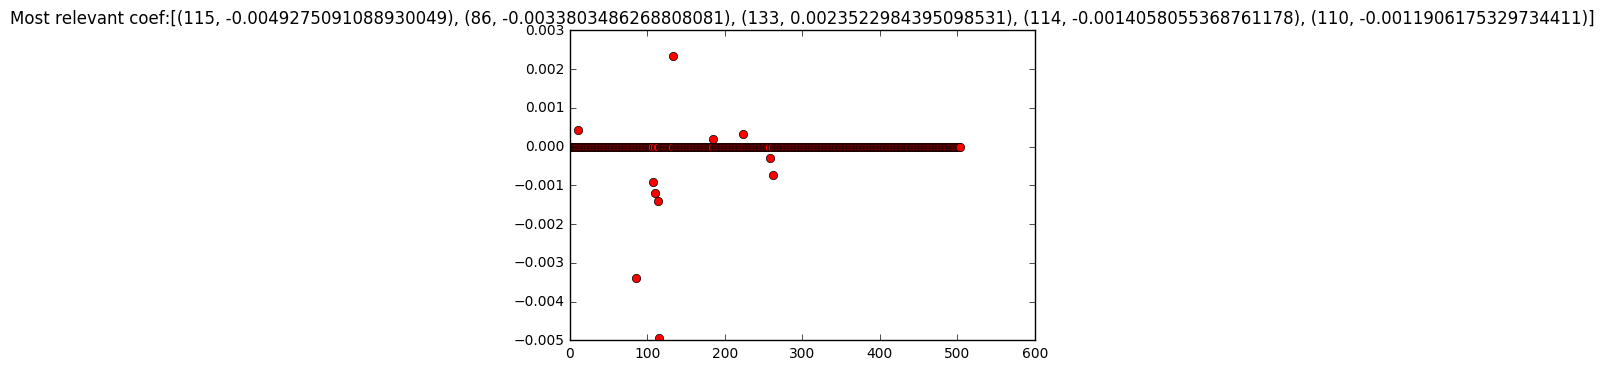

Saved predictions into mean_var_mean_std_hist500_scale1_LassoPure_alpha210_FULL.csv


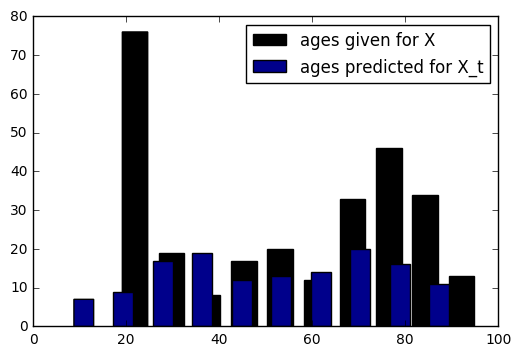

Saved age diagrams as mean_var_mean_std_hist500_scale1_LassoPure_alpha210_FULL*.png


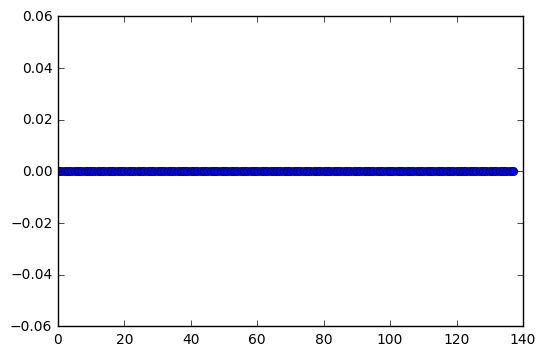

 ========= x ========== 
[[  1.50725930e+09   1.51216940e+12   1.64032931e+15 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.51397922e+09   1.54599576e+12   1.71971056e+15 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.52006085e+09   1.57387665e+12   1.76660383e+15 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]
 ..., 
 [  1.52169988e+09   1.54359292e+12   1.68726157e+15 ...,   1.00000000e+00
    0.00000000e+00   1.00000000e+00]
 [  1.52123657e+09   1.56384761e+12   1.75263246e+15 ...,   6.00000000e+00
    0.00000000e+00   1.00000000e+00]
 [  1.53099490e+09   1.57102397e+12   1.74253079e+15 ...,   1.00000000e+00
    6.00000000e+00   3.00000000e+00]]

 ========= y_t_pp ========== 
[60.41677586954188, 70.556846873091274, 51.259856559229263, 74.547095580553503, 71.505907608786515, 72.346464000209949, 52.727406903739166, 54.874465555419022, 63.227983499721631, 52.886178566197771, 29.826328352545204, 55.075224163736607, 61.901448596608361, 38.1

In [15]:
doStuff(al=210,kernel="rbf") # ??

## Histogram deviation from mean and Lasso coefficients

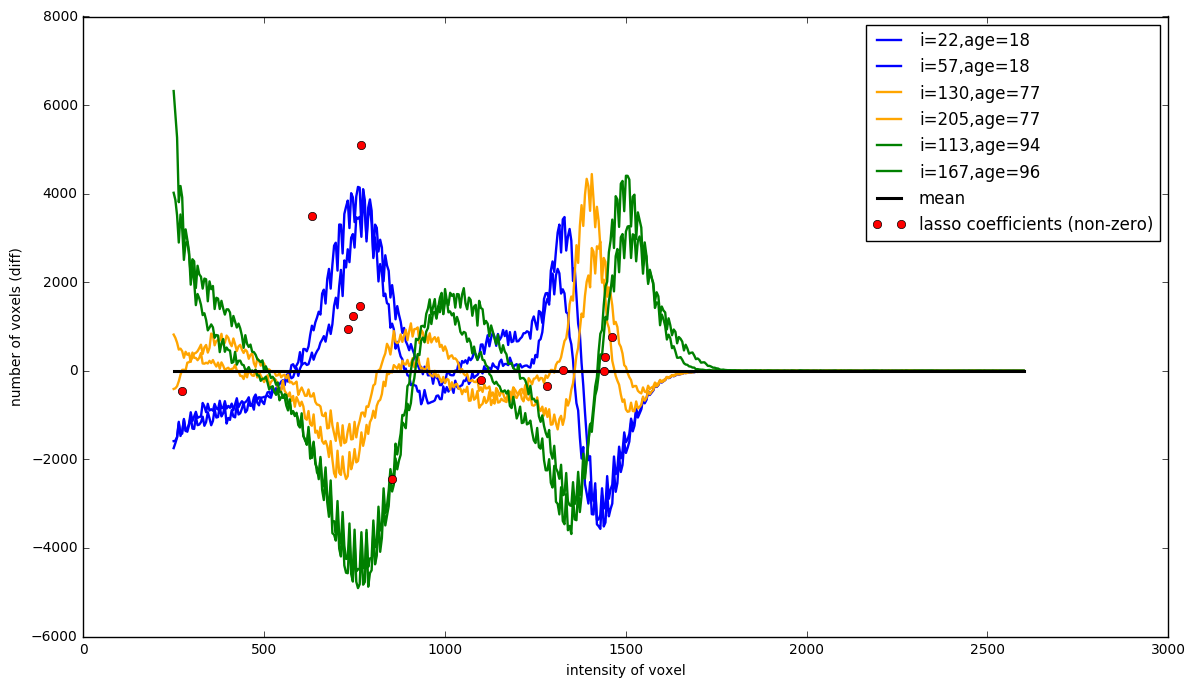

In [19]:
# show various histograms by age. revealing...
withDiff = True
plt.clf()
df = np.mean(x[:,5:],axis=0) if withDiff else np.zeros(len(x[0,5:]))
g,df_word = ("diff_to_mean_"," (diff)") if withDiff else ("","")
fig = plt.figure(1)
fig.set_size_inches(14,8)
sortI = range(0,n_max)
sortI.sort(key=lambda i:y[i])
for si,i in enumerate(sortI[:2] + sortI[205:207] + sortI[-2:]):
    s = "i=%s,age=%s" % (i,y[i])
    c = "blue" if y[i] <= 25 else ("orange" if (23<= y[i] < 90) else "green")
    plt.plot(bins,x[i,5:]-df,label=s,color=c,linewidth=1.7)
plt.plot(bins,df*0,label="mean",color="black",linewidth=2.2)
coeffs = result[5].coef_[5:]
coeffs_scaled = coeffs/np.mean(coeffs)*np.mean(x[0,5:]-df)/4 # scale for visibility
nonZero = [i for i in range(0,space-1) if coeffs[i]!=0]
plt.plot(bins[nonZero],coeffs_scaled[nonZero],"ro",
         label="lasso coefficients (non-zero)")
plt.ylabel("number of voxels"+df_word)
plt.xlabel("intensity of voxel")
plt.legend(loc='upper right')
plt.savefig("gray-density-patients-by-age"+g+".png")
if not withDiff:
    plt.yscale('log')
    plt.savefig("gray-density-patients-by-age_logscale"+g+".png")
plt.show()

## Visualize all Histograms deviations per Age

i=22...
i=247...
i=1...
i=239...
i=53...
i=144...
i=97...
i=260...


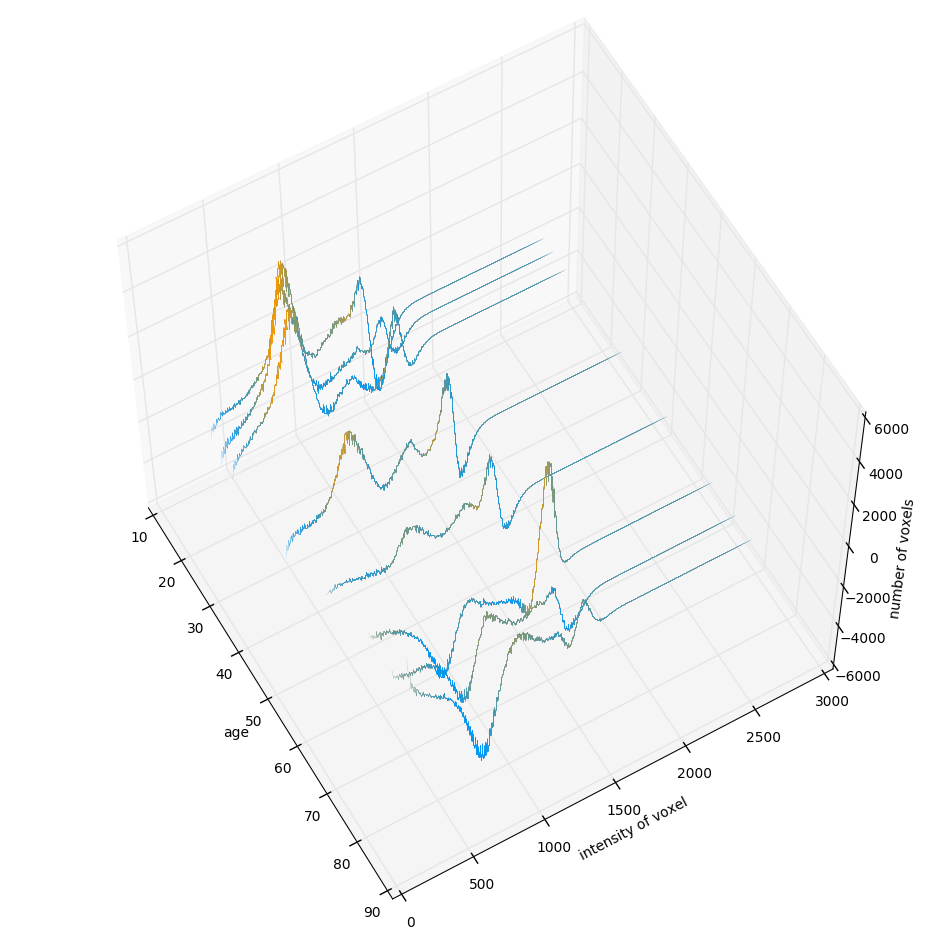

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt

plt.clf()
fig = plt.figure()
fig.set_size_inches(12,12)
ax = fig.gca(projection='3d')
tr = np.arange(0,len(bins))
maxZ = 8400
minZ = -7000
def zo(f):
    h = (f-minZ)/float(maxZ-minZ)
    e = float(4)
    g = max(min(h*e+(1-e)/2,1),0)
    return [g,0.6,1-g,0.5]
k = 50
for i in range(0,n_max,35):
    i=sortI[i]
    print "i=%s..."%i
    Z = x[i,5:]-df # Nvoxels
    Y = bins# intensity
    X = tr*0+y[i] # age
    for j in range(0,len(X)-k):
        ax.plot(X[j:j+k],Y[j:j+k],Z[j:j+k],linewidth=0.1,c=zo(Z[j+(k/2)]))
ax.set_xlabel("age")
ax.set_ylabel("intensity of voxel")
ax.set_zlabel("number of voxels")
ax.view_init(elev=60, azim=330)
#fig.savefig("all-histograms-by-age.png")
plt.show()